In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import pickle
from utils import get_best_t
from utils import get_theory_curves
from data_load import load_minimum, collect_minima

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
font = {'family' : 'Arial',
    'weight' : 'medium',
    'size'   : 14,
    'style'  : 'normal'}
matplotlib.rc('font', **font)

In [3]:
# -------------------------------------------------------------------
# States / conditions per dataset
# -------------------------------------------------------------------

states_zhang = ["mid_G1", "late_G1"]
states_abramo = ["4h", "5h", "6h", "7h"]

states_bonev = [
    "HiC_CN_1.mm10.mapq_30.1000.mcool",
    "HiC_CN_2.mm10.mapq_30.1000.mcool",
    "HiC_CN_3.mm10.mapq_30.1000.mcool",
    "HiC_CN_4.mm10.mapq_30.1000.mcool",
    "HiC_CN_5.mm10.mapq_30.1000.mcool",
    "HiC_CN_6.mm10.mapq_30.1000.mcool",
    "HiC_ES_1.mm10.mapq_30.1000.mcool",
    "HiC_ES_2.mm10.mapq_30.1000.mcool",
    "HiC_ES_3.mm10.mapq_30.1000.mcool",
    "HiC_ES_4.mm10.mapq_30.1000.mcool",
    "HiC_ncx_CN_1.mm10.mapq_30.1000.mcool",
    "HiC_ncx_CN_2.mm10.mapq_30.1000.mcool",
    "HiC_ncx_CN_3.mm10.mapq_30.1000.mcool",
    "HiC_ncx_CN_4.mm10.mapq_30.1000.mcool",
]

states_rao = [
    "GM12878_inSitu_DpnII.hg38.mapq_30.1000.mcool",
    "HMEC_inSitu_MboI.hg38.mapq_30.1000.mcool",
    "HUVEC_inSitu_MboI.hg38.mapq_30.1000.mcool",
    "IMR90_inSitu_MboI.hg38.mapq_30.1000.mcool",
    "K562_inSitu_MboI.hg38.mapq_30.1000.mcool",
    "KBM7_inSitu_MboI.hg38.mapq_30.1000.mcool",
    "NHEK_inSitu_MboI.hg38.mapq_30.1000.mcool",
]

states_hff = [
    "U54-HFFc6-DSG-DpnII-R1-R2_hg38.mapq_30.1000.mcool",
    "hg38_deep",
]

states_esc = [
    "U54-ESC4DN-DSG-DpnII-R1-R2_hg38.mapq_30.1000.mcool",
    "U54-ESC4DN-FA-DpnII-R1-R2_hg38.mapq_30.1000.mcool",
]

states_wutz = ["control.hg38.mapq_30.1000.mcool"]
states_schwarzer = ["TAM.mm10.mapq_30.1000.mcool"]


In [8]:
data_dir = "../data"

# Abramo (HeLa, mitotic exit time course)
xs_abramo, ys_abramo = collect_minima("abramo", states_abramo, data_dir)

# Zhang (mESC, mitotic exit time course)
xs_zhang, ys_zhang = collect_minima("zhang", states_zhang, data_dir)

# Bonev (CN/ES)
xs_bonev, ys_bonev = collect_minima("bonev", states_bonev, data_dir)

# Rao (GM12878 etc.)
xs_rao, ys_rao = collect_minima("rao", states_rao, data_dir)

# Oksuz HFF (HFF)
xs_hff, ys_hff = collect_minima("oksuz_hff", states_hff, data_dir)

# Oksuz ESC (hESC protocols)
xs_esc, ys_esc = collect_minima("oksuz_esc", states_esc, data_dir)

# Wutz (control)
xs_wutz, ys_wutz = collect_minima("wutz", states_wutz, data_dir)

# Schwarzer (TAM control)
xs_sch, ys_sch = collect_minima("schwarzer", states_schwarzer, data_dir)

In [9]:
T_values = np.arange(100, 301, 10)
v0_values = [0.0001, 0.2, 0.4, 0.6, 0.8, 1, 1.5, 2, 2.5, 3, 3.5,
             4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.6,
             10, 10.5, 11, 11.5, 12, 12.5, 13, 14, 15]

In [10]:
# Get theoretical positions and depths of log-derivative minima
# across a grid of loop periods T and effective fragment lengths v0

theory_xmins, theory_ymins, s_grid, v0_values = get_theory_curves()

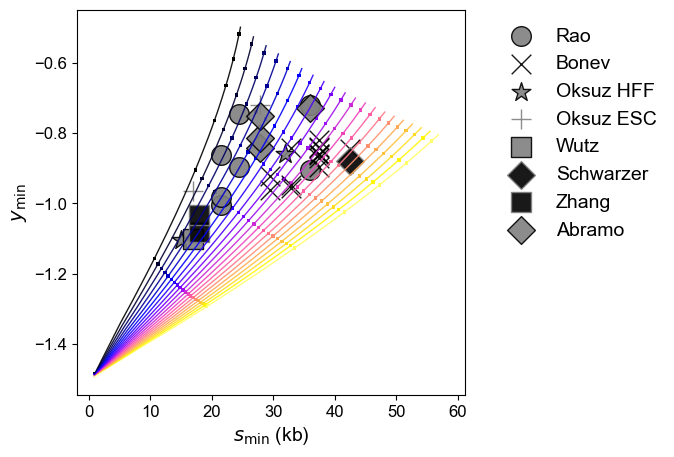

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------------------
# 1. Plot theoretical "fountain" of curves (s_min vs y_min)
# --------------------------------------------------------------------

fig = plt.figure(figsize=(5, 5)) 

# colormap across T
cmap = plt.get_cmap("gnuplot2")
norm = plt.Normalize(vmin=T_values.min(), vmax=T_values.max())

marker_step = 5  # show a marker every 5 v0-values to avoid clutter

for T in T_values:
    color = cmap(norm(T))

    x_row = theory_xmins[T]  # s_min(T, v0)
    y_row = theory_ymins[T]  # y_min(T, v0)

    # full curve
    plt.plot(
        x_row,
        y_row,
        color=color,
        linewidth=1.0,
        alpha=0.9,
    )

    # sparse markers along each curve
    plt.scatter(
        x_row[::marker_step],
        y_row[::marker_step],
        color=color,
        marker="s",
        s=6,
        edgecolors="none",
    )

# --------------------------------------------------------------------
# 2. Scatter experimental minima on top
#    (xs_* are in bp -> convert to kb; ys_* are already log-derivative)
# --------------------------------------------------------------------

dataset_styles = {
    "Rao":      dict(xs=xs_rao,    ys=ys_rao,    marker="o", color="gray", edgecolor="k"),
    "Bonev":    dict(xs=xs_bonev,  ys=ys_bonev,  marker="x", color="k",   edgecolor=None),
    "Oksuz HFF":dict(xs=xs_hff,    ys=ys_hff,    marker="*", color="gray", edgecolor="k"),
    "Oksuz ESC":dict(xs=xs_esc,    ys=ys_esc,    marker="+", color="gray", edgecolor=None),
    "Wutz":     dict(xs=xs_wutz,   ys=ys_wutz,   marker="s", color="gray", edgecolor="k"),
    "Schwarzer":dict(xs=xs_sch,    ys=ys_sch,    marker="D", color="k",   edgecolor="gray"),
    "Zhang":    dict(xs=xs_zhang,  ys=ys_zhang,  marker="s", color="k",   edgecolor="gray"),
    "Abramo":   dict(xs=xs_abramo, ys=ys_abramo, marker="D", color="gray",edgecolor="k"),
}

for name, style in dataset_styles.items():
    plt.scatter(
        style["xs"] / 1000.0,  # bp -> kb
        style["ys"],
        s=200,
        marker=style["marker"],
        facecolor=style["color"],
        edgecolor=style["edgecolor"],
        linewidths=1,
        alpha=0.9,
        label=name,
    )

plt.xlabel(r"$s_{\min}$ (kb)")
plt.ylabel(r"$y_{\min}$")
plt.tick_params(labelsize=12)

# optional: legend outside to avoid covering points
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1.0), loc="upper left")

plt.show()


In [22]:
all_T = []
all_v0 = []
all_density = []

for name, style in dataset_styles.items():
    Ts_dataset = []
    v0_dataset = []
    dens_dataset = []

    for x_bp, y_obs in zip(style["xs"], style["ys"]):
        # convert s_min from bp to kb
        x_kb = x_bp / 1000.0

        T_best, v0_best, err = get_best_t(
            (x_kb, y_obs),
            theory_xmins=theory_xmins,
            theory_ymins=theory_ymins,
            T_values=T_values,
            v0_values=v0_values,
            x_weight=1e-4,
        )

        Ts_dataset.append(T_best)
        v0_dataset.append(v0_best)
        dens_dataset.append(1000.0 / T_best)  # loops per Mb

        all_T.append(T_best)
        all_v0.append(v0_best)
        all_density.append(1000.0 / T_best)

    Ts_dataset = np.array(Ts_dataset)
    v0_dataset = np.array(v0_dataset)
    dens_dataset = np.array(dens_dataset)

    print(f"{name}")
    print(f"  T = {Ts_dataset.mean():.1f} ± {Ts_dataset.std():.1f} kb")
    print(f"  v0_eff = {v0_dataset.mean():.2f} ± {v0_dataset.std():.2f} kb")
    print(f"  density = {dens_dataset.mean():.2f} ± {dens_dataset.std():.2f} loops/Mb")
    print()

all_T = np.array(all_T)
all_v0 = np.array(all_v0)
all_density = np.array(all_density)

print("All datasets combined:")
print(f"  T = {all_T.mean():.1f} ± {all_T.std():.1f} kb")
print(f"  v0_eff = {all_v0.mean():.2f} ± {all_v0.std():.2f} kb")
print(f"  density = {all_density.mean():.2f} ± {all_density.std():.2f} loops/Mb")


Rao
  T = 150.0 ± 29.3 kb
  v0_eff = 6.29 ± 2.79 kb
  density = 6.89 ± 1.19 loops/Mb

Bonev
  T = 199.3 ± 14.4 kb
  v0_eff = 7.83 ± 1.53 kb
  density = 5.04 ± 0.37 loops/Mb

Oksuz HFF
  T = 140.0 ± 30.0 kb
  v0_eff = 4.25 ± 2.75 kb
  density = 7.49 ± 1.60 loops/Mb

Oksuz ESC
  T = 120.0 ± 10.0 kb
  v0_eff = 6.00 ± 3.00 kb
  density = 8.39 ± 0.70 loops/Mb

Wutz
  T = 140.0 ± 0.0 kb
  v0_eff = 2.00 ± 0.00 kb
  density = 7.14 ± 0.00 loops/Mb

Schwarzer
  T = 240.0 ± 0.0 kb
  v0_eff = 9.00 ± 0.00 kb
  density = 4.17 ± 0.00 loops/Mb

Zhang
  T = 130.0 ± 0.0 kb
  v0_eff = 2.25 ± 0.25 kb
  density = 7.69 ± 0.00 loops/Mb

Abramo
  T = 150.0 ± 12.2 kb
  v0_eff = 8.38 ± 1.95 kb
  density = 6.71 ± 0.52 loops/Mb

All datasets combined:
  T = 169.7 ± 36.4 kb
  v0_eff = 6.76 ± 2.73 kb
  density = 6.19 ± 1.40 loops/Mb


In [13]:
v0_values[::marker_step]

array([1.0e-04, 1.0e+00, 3.5e+00, 6.0e+00, 8.5e+00, 1.1e+01, 1.4e+01])